In [332]:
# Pandas for table processing
import pandas as pd
import re
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for auxilary data science tasks: dividing the dataset to train and test and metrics summary generation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, accuracy_score

In [333]:
data = pd.read_csv("Glass_Type.csv")

In [334]:
data

,Unnamed: 0,Unnamed: 0.1,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,'vehic wind float'
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,headlamps
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,'build wind float'
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,'build wind non-float'
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,'build wind non-float'
...,...,...,...,...,...,...,...,...,...,...,...,...
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,headlamps
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,containers
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,'vehic wind float'
192598,192598,191,1.51888,14.99,0.78,1.74,72.50,0.00,9.95,0.00,0.00,tableware


In [335]:
# Due to LightGBMError: Do not support special JSON characters in feature name. 
# Solution found in: https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [336]:
data.Type.value_counts()

'build wind non-float'    68251
'build wind float'        62455
headlamps                 26201
'vehic wind float'        15233
containers                12038
tableware                  8422
Name: Type, dtype: int64

In [337]:
# Labels encoding from categories to Integers
data['Type'] = LabelEncoder().fit_transform(data['Type'])
# 0 -> 'build wind float'
# 1 -> 'build wind non-float'
# 2 -> 'vehic wind float'
# 3 -> containers
# 4 -> headlamps
# 5 -> tableware

In [338]:
def binarize(x):
    if x==5:
        value=0
    else:
        value=1
    return value
#data['Type'] = data['Type'].map(binarize)

In [339]:
data

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,2
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,4
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,0
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,1
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,4
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,3
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,2
192598,192598,191,1.51888,14.99,0.78,1.74,72.50,0.00,9.95,0.00,0.00,5


In [340]:
# get all data of the omitted class "tableware"
omitted_class = data.loc[data['Type'] == 5]

In [341]:
data_without_omitted_class = data.loc[data['Type'] != 5]

In [342]:
data_without_omitted_class

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,2
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,4
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,0
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,1
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192594,192594,4629,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03,0
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,4
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,3
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,2


In [343]:
data_without_omitted_class

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,2
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,4
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,0
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,1
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192594,192594,4629,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03,0
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,4
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,3
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,2


In [344]:
X_train, X_test, Y_train, Y_test = train_test_split(data_without_omitted_class.drop(columns=["Type"]), data_without_omitted_class.Type,
                                                    train_size=0.95, stratify=data_without_omitted_class.Type, random_state=42)

In [345]:
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=Y_train)
#setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value
#training the model
clf=lgb.train(params,d_train,100)  #training the model on 100 epocs
#prediction on the test dataset
y_pred=clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 174969, number of used features: 11
[LightGBM] [Info] Start training from score -1.081460
[LightGBM] [Info] Start training from score -0.992702
[LightGBM] [Info] Start training from score -2.492462
[LightGBM] [Info] Start training from score -2.727843
[LightGBM] [Info] Start training from score -1.950103
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain,

In [346]:
#argmax() method 
y_pred = [np.argmax(line) for line in y_pred]

In [347]:
y_pred

[4,
 4,
 2,
 4,
 4,
 4,
 1,
 4,
 1,
 0,
 2,
 1,
 4,
 1,
 1,
 3,
 4,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 4,
 1,
 0,
 1,
 0,
 0,
 0,
 4,
 1,
 1,
 4,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 4,
 0,
 1,
 2,
 0,
 0,
 1,
 4,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 4,
 1,
 1,
 0,
 1,
 1,
 4,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 4,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 4,
 1,
 0,
 0,
 1,
 4,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 4,
 4,
 2,
 0,
 1,
 1,
 0,
 3,
 1,
 0,
 2,
 4,
 2,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 3,
 4,
 1,
 4,
 1,
 1,
 0,
 4,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 4,
 1,
 4,
 2,
 1,
 0,
 2,
 0,
 2,
 4,
 0,
 4,
 4,
 1,
 1,
 4,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 4,
 0,
 0,
 1,
 3,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 4,
 3,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 4,
 1,
 0,
 0,
 1,
 4,
 0,
 0,
 4,
 1,
 1,
 0,
 4,
 1,
 0,
 1,
 0,
 1,
 2,
 4,
 0,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 0,
 0,


In [348]:
#using precision score for error metrics
precision_score(y_pred,Y_test,average=None).mean()

1.0

In [349]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3123
           1       1.00      1.00      1.00      3412
           2       1.00      1.00      1.00       762
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00      1310

    accuracy                           1.00      9209
   macro avg       1.00      1.00      1.00      9209
weighted avg       1.00      1.00      1.00      9209



In [350]:
classification_result = clf.predict(X_test)

In [351]:
# Get the max value from each array from numpy matrix
# axis=1 to find max from each row
# Calculate the confidence scores SC of the winning classes, in case when 
# the trained classifier was  tested on dataset without omitted class
winningClassCs = np.amax(classification_result, axis=1)
print(winningClassCs)
print(len(winningClassCs))

[0.99156095 0.99156095 0.98975858 ... 0.9904864  0.9939833  0.99424686]
9209


In [352]:
accuracy_score(Y_test, y_pred)

1.0

In [353]:
# Test on omitted class
X_test_omitted = omitted_class.iloc[:,:-1] # all colmns without the last column
Y_test_omitted = omitted_class.iloc[:,-1:] # last colmn
y_pred_omitted=clf.predict(X_test_omitted)

In [354]:
#argmax() method 
y_pred_omitted = [np.argmax(line) for line in y_pred_omitted]

In [355]:
print(classification_report(Y_test_omitted, y_pred_omitted))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00    8422.0

    accuracy                           0.00    8422.0
   macro avg       0.00      0.00      0.00    8422.0
weighted avg       0.00      0.00      0.00    8422.0



c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\sklearn\metric

In [356]:
classification_result_omitted = clf.predict(X_test_omitted)

In [357]:
# Get the max value from each array from numpy matrix
# axis=1 to find max from each row
# Calculate the confidence scores SC of the winning classes, in case when 
# the trained classifier was tested on omitted class dataset
winningClassCsOmitted = np.amax(classification_result_omitted, axis=1)


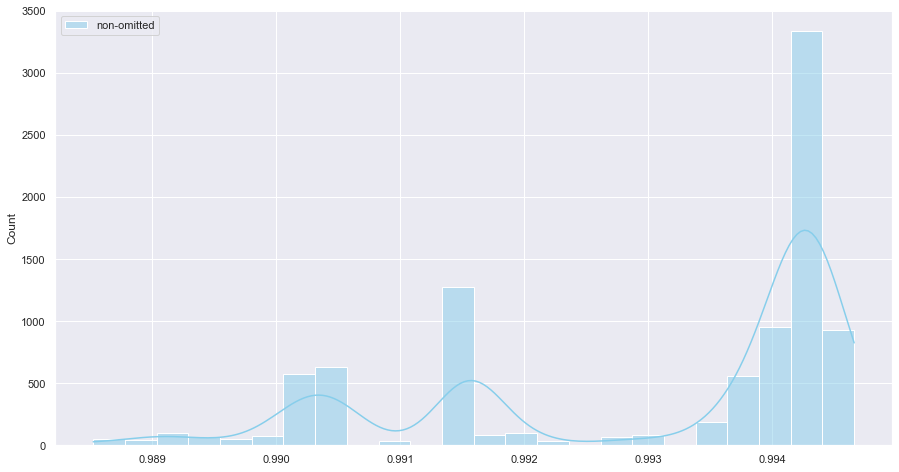

In [358]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset("iris")
plt.figure(figsize = (15,8))

sns.histplot(data=winningClassCs, color="skyblue", label="non-omitted", kde=True)

plt.legend() 
plt.show()

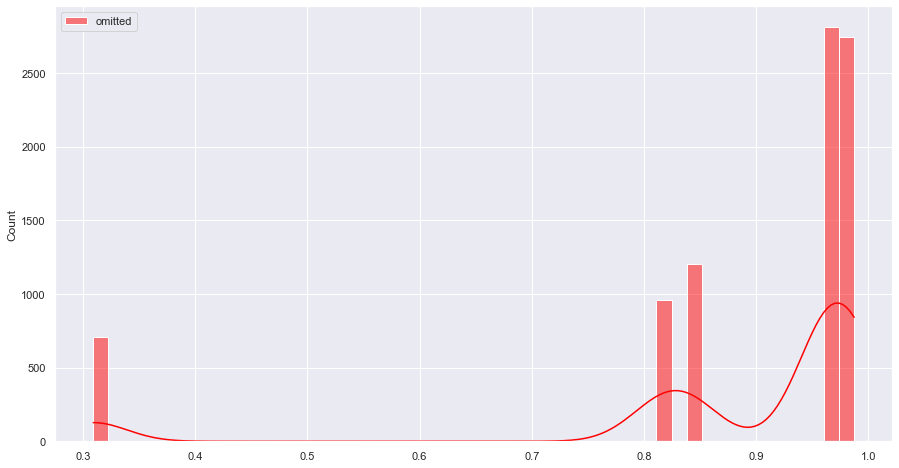

In [359]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset("iris")
plt.figure(figsize = (15,8))

sns.histplot(data=winningClassCsOmitted, color="red", label="omitted", kde=True)

plt.legend() 
plt.show()

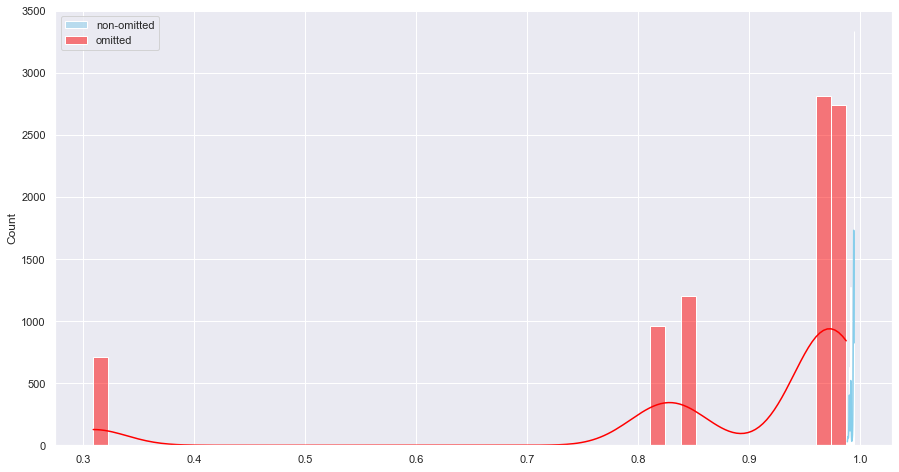

In [360]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset("iris")
plt.figure(figsize = (15,8))

sns.histplot(data=winningClassCs, color="skyblue", label="non-omitted", kde=True)
sns.histplot(data=winningClassCsOmitted, color="red", label="omitted", kde=True)


plt.legend() 
plt.show()

In [361]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [362]:
mean_confidence_interval(winningClassCs)

(0.9930528033265573, 0.9930184868319533, 0.9930871198211614)

#  Drift simulation

In [363]:
len(winningClassCs[:9200]), len(winningClassCsOmitted)

(9200, 8422)

In [364]:
# Split the winning scores of non omitted data into batches of length 20
n=20
#print(winningClassCs[:9200].reshape(460,20))
winningClassCsInBatches = winningClassCs[:9200].reshape(460,20)
#winningClassCsInBatches=np.array([winningClassCs[i:i + n] for i in range(0, len(winningClassCs), n)])
#print(winningClassCsInBatches)
#print(winningClassCsOmitted)

In [365]:
def sudden_quarter():
    #Lists of before and after the changepoint
    befor_cp = winningClassCsInBatches[:230]
    after_cp = winningClassCsInBatches[230:]
    omittedToBeStacked = winningClassCsOmitted[:5*len(after_cp)].reshape(len(after_cp),5)
    print(befor_cp.shape)
    x = np.concatenate((after_cp[:,:15],omittedToBeStacked),axis=1)
    print(x.shape)
    x = np.concatenate([befor_cp,x])
    return x
print(sudden_quarter())

(230, 20)
(230, 20)
[[0.99156095 0.99156095 0.98975858 ... 0.99456825 0.99436126 0.9942455 ]
 [0.9939217  0.99462994 0.99464366 ... 0.99383543 0.99424544 0.9943129 ]
 [0.9939217  0.99411483 0.99426069 ... 0.99430668 0.99273872 0.99377153]
 ...
 [0.99381941 0.99426069 0.9942455  ... 0.98120213 0.98748764 0.98121663]
 [0.99156095 0.99448529 0.99156095 ... 0.96265364 0.96239066 0.30904775]
 [0.99432076 0.99019958 0.99429418 ... 0.84094905 0.98120213 0.84094905]]


In [366]:
# 461 is the length of clean batches
# d = 230 the batch of the changepoint
# d =< 230 no drift 
# d > drift with proportion p

'''
sudden_quarter = for i in winningClassCsInBatches[:230]
sudden_half = 
sudden_full = 
'''

'\nsudden_quarter = for i in winningClassCsInBatches[:230]\nsudden_half = \nsudden_full = \n'

In [367]:
import rpy2
print(rpy2.__version__)

3.5.1


In [368]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

In [369]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x000002B494F66C48> [RTYPES.NILSXP]

In [370]:
# R package names
packnames = ('cpm')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [371]:
cpm = rpackages.importr("cpm")

In [372]:
from rpy2.robjects import FloatVector
ctl = FloatVector([4.17,5.58,5.18,6.11,4.50,4.61,5.17,4.53,5.33,5.14])

In [373]:
a = cpm.detectChangePoint(ctl,"Student",ARL0=500,startup=20)

In [374]:
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,0
0,"[4.17, 5.58, 5.18, 6.11, 4.5, 4.61, 5.17, 4.53..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[0]
4,[0]
5,[False]


In [375]:
x = sudden_quarter()

(230, 20)
(230, 20)


In [376]:
x.shape

(460, 20)

In [377]:
x = x.flatten()

In [378]:
x

array([0.99156095, 0.99156095, 0.98975858, ..., 0.84094905, 0.98120213,
       0.84094905])

In [379]:
type(x)

numpy.ndarray

In [380]:
vector = x.tolist()

In [381]:
vectorToFloatVector = FloatVector(vector)

In [382]:
a = cpm.detectChangePoint(vectorToFloatVector,"Cramer-von-Mises",ARL0=9000,startup=20)

In [383]:
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[4615]
4,[4620]
5,[True]


In [384]:
dataset.iloc[[1]].values

array([[<rpy2.robjects.vectors.FloatVector object at 0x000002B494A72FC8> [RTYPES.REALSXP]
        R classes: ('numeric',)
        [0.000000, 0.000000, 0.000000, 0.000000, ..., 7.881847, 7.922419, 8.672612, 10.899454]]],
      dtype=object)

In [385]:
dataset.iloc[[1]].values.tolist()

[[<rpy2.robjects.vectors.FloatVector object at 0x000002B494A72FC8> [RTYPES.REALSXP]
  R classes: ('numeric',)
  [0.000000, 0.000000, 0.000000, 0.000000, ..., 7.881847, 7.922419, 8.672612, 10.899454]]]

In [386]:
a = cpm.detectChangePoint(vectorToFloatVector,"Student",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[3209]
4,[3217]
5,[True]
